In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot
import numpy
import scipy.optimize
import scipy.stats
import ipywidgets

import calibr8

### Synthetic groundtruth

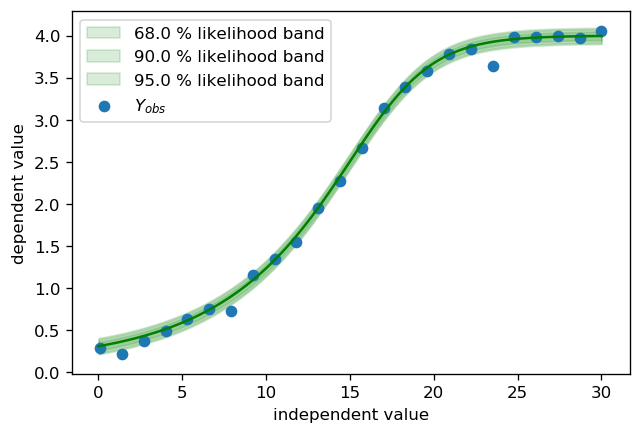

In [3]:
θ_true = (0.1, 4, 15, 0.3, 1)
σ_true = 0.05
df_true = 3
X = numpy.linspace(0.1, 30, 24)
X_dense = numpy.linspace(0, 30, 100)
Y = calibr8.asymmetric_logistic(X, θ_true)
Y = scipy.stats.t.rvs(loc=Y, scale=σ_true, df=df_true)

fig, ax = pyplot.subplots(dpi=120)

calibr8.plot_norm_band(ax, X_dense, calibr8.asymmetric_logistic(X_dense, θ_true), σ_true)

ax.scatter(X, Y, label='$Y_{obs}$')

ax.set_xlabel('independent value')
ax.set_ylabel('dependent value')
ax.legend()
pyplot.show()

### Model definition

In [5]:
class AsymmetricTModelV1(calibr8.BaseAsymmetricLogisticT):
    def __init__(self):
        super().__init__(independent_key='independent', dependent_key='dependent', scale_degree=0)

### Model fit

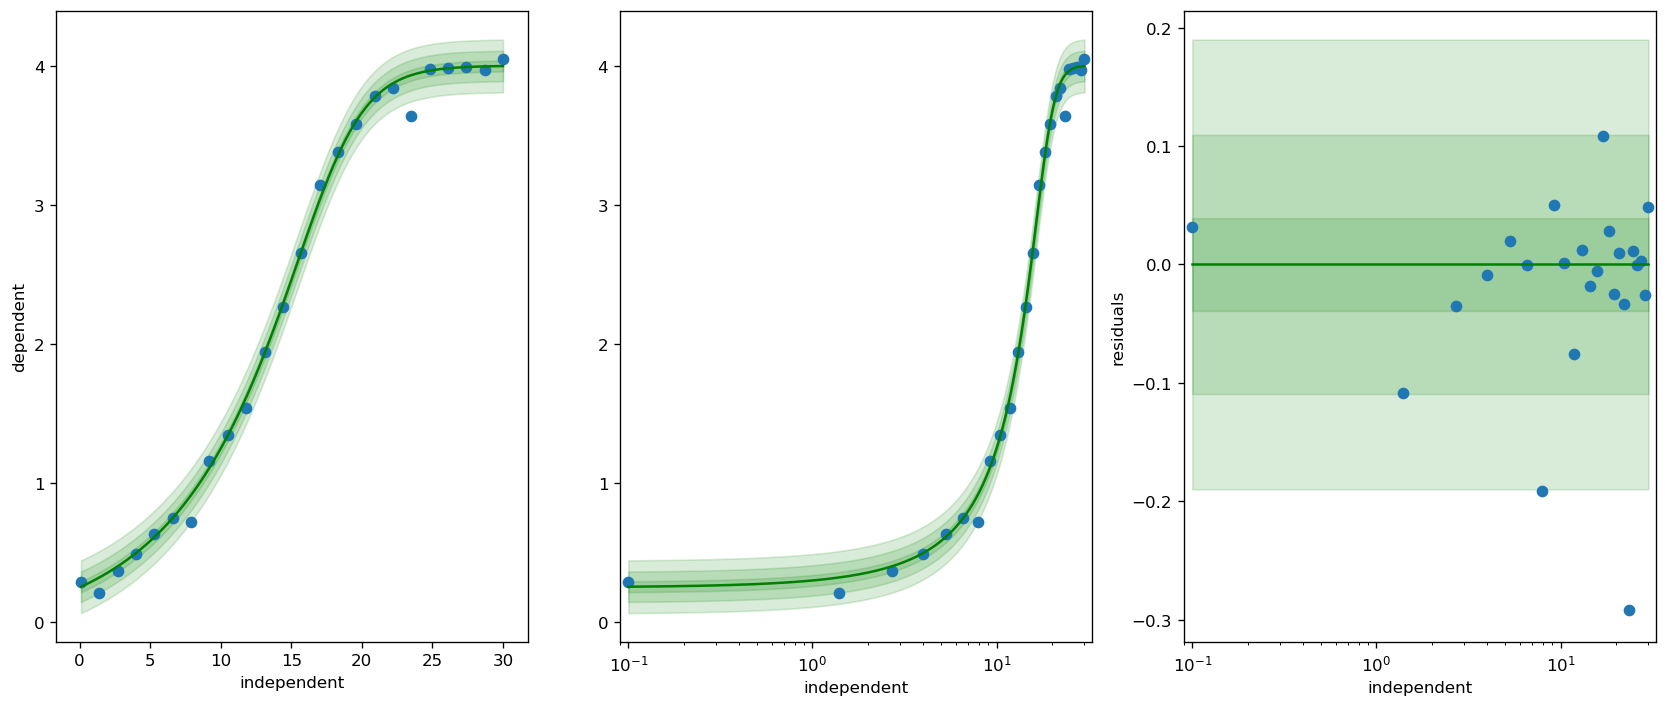

In [8]:
model = AsymmetricTModelV1()
calibr8.fit_scipy(
    model,
    independent=X, dependent=Y,
    theta_guess=calibr8.guess_asymmetric_logistic_theta(X, Y) + [0.01, 45],
    #theta_guess=θ_true + (σ_true, df_true),
    theta_bounds=calibr8.guess_asymmetric_logistic_bounds(X, Y) + [(0.01, 0.5), (1, 50)]
)

fig, axs = calibr8.plot_model(model)
fig.tight_layout()
pyplot.show()

### Visualization

In [95]:
def plot(y_obs=0.5, as_pdf:bool=False, a=0, b=30):
    y_obs = numpy.atleast_1d(y_obs)
    
    def likelihood(x, y):
        loc, scale, df = model.predict_dependent(x)
        # get log-probs for all observations
        logpdfs = [
            scipy.stats.t.logpdf(y_, loc=loc, scale=scale, df=df)
            for y_ in y
        ]
        # sum them and exp them (numerically better than numpy.prod of pdfs)
        return numpy.exp(numpy.sum(logpdfs, axis=0))
    
    fig, ax = pyplot.subplots(dpi=120)
    # x-coordinates for the plot
    x_integrate = numpy.linspace(0, 30, 1000)

    if as_pdf:
        likelihood_integral, integral_error = scipy.integrate.quad(
            func=likelihood,
            # by restricting the integral into the interval [a,b], the resulting PDF is
            # identical to the posterior with a Uniform(a, b) prior.
            # 1. prior probability is constant in [a,b]
            # 2. prior probability is 0 outside of [a,b]
            # > numerical integral is only computed in [a,b], but because of 1. and 2., it's
            #   identical to the integral over [-∞,+∞]
            a=a, b=b,
            args=(y_obs,)
        )
        ax.plot(x_integrate, likelihood(x_integrate, y_obs) / likelihood_integral, label='probability(x)')
    else:
        ax.plot(x_integrate, likelihood(x_integrate, y_obs), label='likelihood(x)')
        
    for yo in y_obs:
        ax.axvline(model.predict_independent(yo), linestyle='--', label='predict_independent')
    
    ax.legend()
    ax.set_xlabel('independent variable')
    ax.set_ylabel('$p(x\ |\ y_{obs})$')
    return fig, ax

ipywidgets.interact(
    plot,
    y_obs=θ_true[0:2],
    as_pdf=True,
    a=ipywidgets.fixed(0),
    b=ipywidgets.fixed(30)
);

interactive(children=(FloatSlider(value=0.5, description='y_obs', max=4.0, min=0.1), Checkbox(value=True, desc…

### Comparison with MCMC

In [86]:
y_obs = numpy.array([3.8,3.9])
a = 0
b = 30

trace = model.infer_independent(
    y=y_obs,
    lower=a, upper=b
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [independent]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


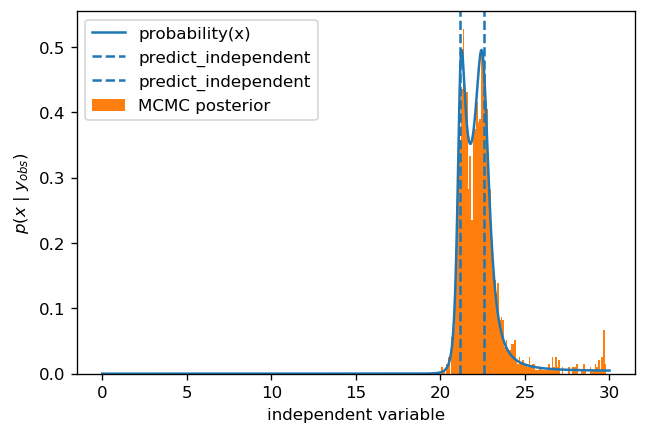

In [93]:
fig, ax = plot(y_obs=y_obs, as_pdf=True)
ax.hist(trace['independent'][:,0], density=True, bins=100, label='MCMC posterior')
ax.legend()
pyplot.show()